In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
pd.set_option('display.max_columns', 500)
import sys, os
from sklearn.linear_model import LogisticRegression
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

c:\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from derm7pt.dataset import Derm7PtDataset, Derm7PtDatasetGroupInfrequent
from derm7pt.vis import plot_confusion
from derm7pt.kerasutils import deep_features

In [3]:
# CHANGE THIS LINE TO YOUR DATA DIRECTORY.
dir_release = "D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0"
dir_meta = os.path.join(dir_release, 'meta')
dir_images = os.path.join(dir_release, 'images')

In [4]:
meta_df = pd.read_csv(os.path.join(dir_meta, 'meta.csv'))
train_indexes = list(pd.read_csv(os.path.join(dir_meta, 'train_indexes.csv'))['indexes'])
valid_indexes = list(pd.read_csv(os.path.join(dir_meta, 'valid_indexes.csv'))['indexes'])
test_indexes = list(pd.read_csv(os.path.join(dir_meta, 'test_indexes.csv'))['indexes'])

In [5]:
# The full dataset before any grouping of the labels.
derm_data = Derm7PtDataset(dir_images=dir_images, 
                        metadata_df=meta_df.copy(), # Copy as is modified.
                        train_indexes=train_indexes, valid_indexes=valid_indexes, 
                        test_indexes=test_indexes)

# The dataset after grouping infrequent labels.
derm_data_group = Derm7PtDatasetGroupInfrequent(dir_images=dir_images, 
                                             metadata_df=meta_df.copy(), # Copy as is modified.
                                             train_indexes=train_indexes, 
                                             valid_indexes=valid_indexes, 
                                             test_indexes=test_indexes)

In [6]:
derm_data.dataset_stats()

Number of cases: 1011
Number of cases to train: 413
Number of cases to validate: 203
Number of cases to test: 395


In [7]:
# Converted the meta-data to categorical (*_numeric) labels.
derm_data_group.df.head()

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,level_of_diagnostic_difficulty,elevation,location,sex,management,clinic,derm,case_id,notes,diagnosis_numeric,pigment_network_numeric,blue_whitish_veil_numeric,vascular_structures_numeric,pigmentation_numeric,streaks_numeric,dots_and_globules_numeric,regression_structures_numeric
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,medium,nodular,abdomen,female,excision,NEL/NEL025.JPG,NEL/Nel026.jpg,NaN,NaN,0,0,0,1,0,0,0,0
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,low,palpable,head neck,female,excision,NEL/NEL027.JPG,NEL/Nel028.jpg,NaN,NaN,0,0,0,0,0,0,2,0
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,medium,palpable,head neck,female,excision,NEL/Nel032.jpg,NEL/Nel033.jpg,NaN,NaN,0,0,0,1,0,0,2,0
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,low,palpable,lower limbs,male,excision,NEL/NEL034.JPG,NEL/Nel035.jpg,NaN,NaN,0,0,1,1,0,0,2,1
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,high,palpable,upper limbs,female,excision,NEL/NEL036.JPG,NEL/Nel037.jpg,NaN,NaN,0,0,0,0,2,0,0,0


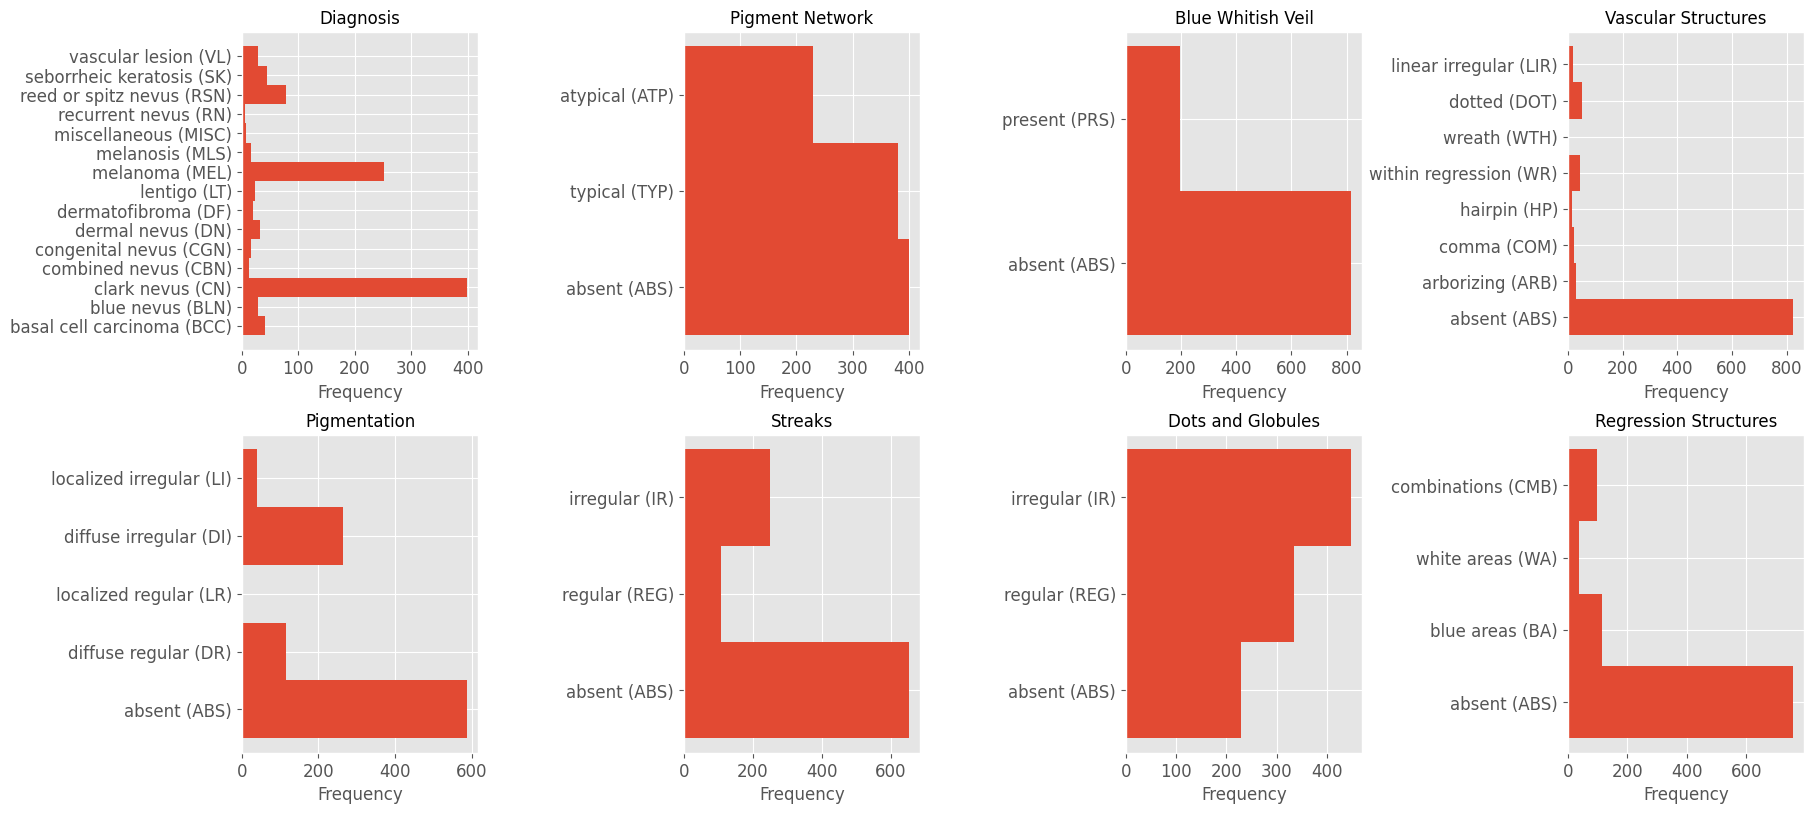

In [8]:
# Distribution of the labels before any grouping (most granular labels).
derm_data.plot_tags_hist(figsize=(18,8), fontsize=12)

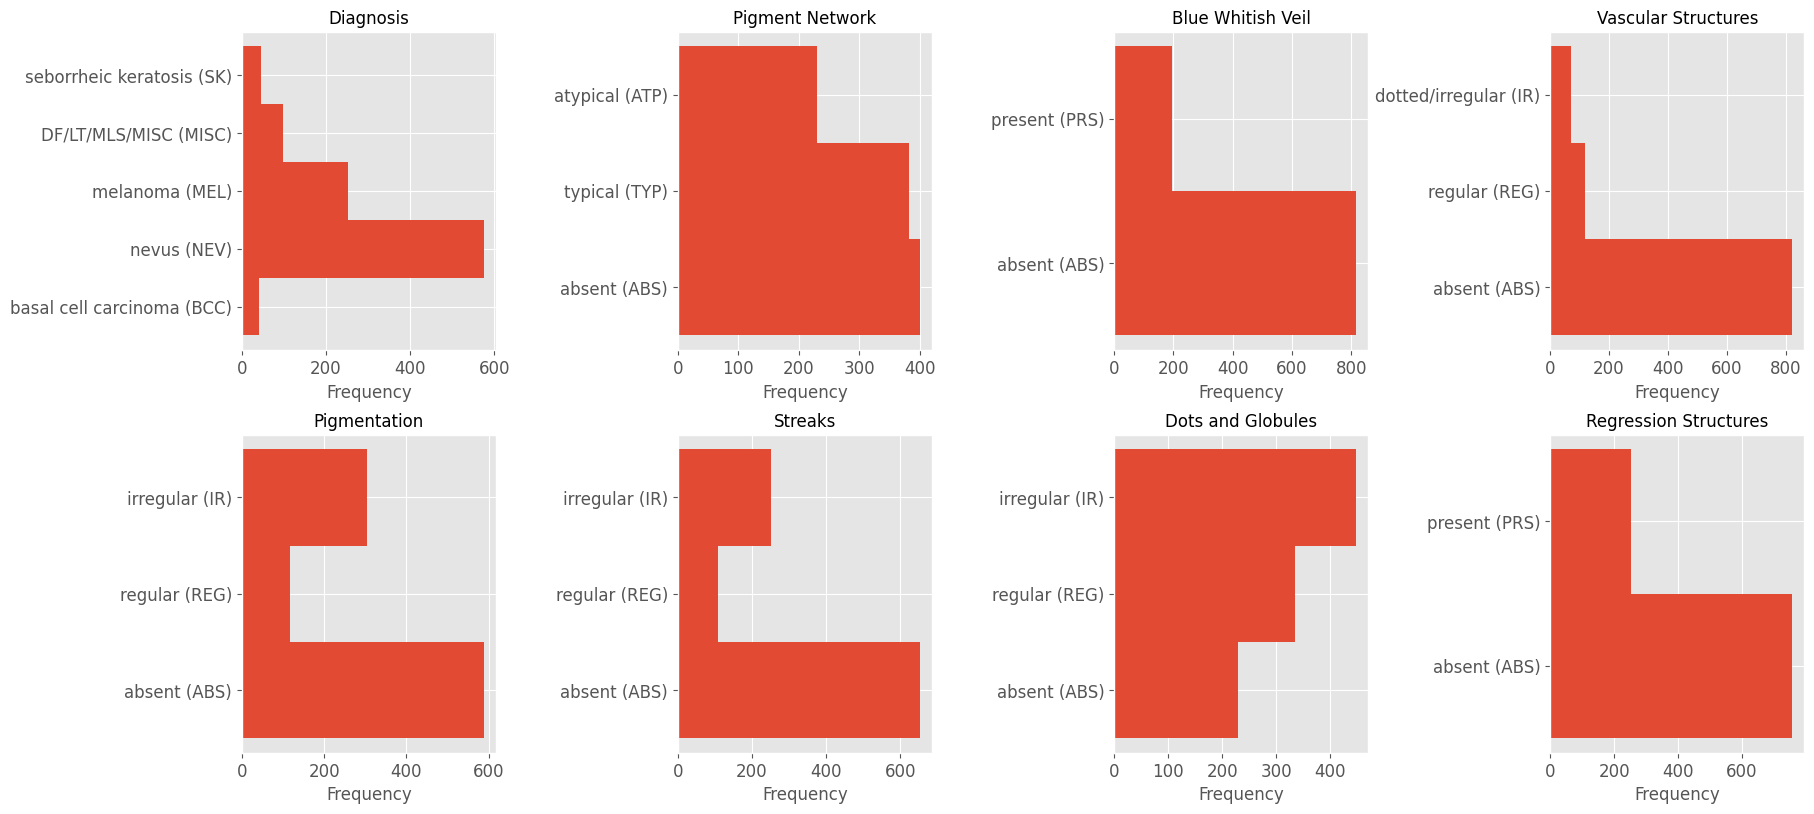

In [9]:
# Distribution of the labels after the grouping.
# We group some clinicially labels as many granular labels occur very infrequently.
derm_data_group.plot_tags_hist(figsize=(18,8), fontsize=12)

case_num                                             4
diagnosis                         basal cell carcinoma
seven_point_score                                    4
pigment_network                                 absent
streaks                                         absent
pigmentation                                    absent
regression_structures                       blue areas
dots_and_globules                            irregular
blue_whitish_veil                              present
vascular_structures                  within regression
level_of_diagnostic_difficulty                     low
elevation                                     palpable
location                                   lower limbs
sex                                               male
management                                    excision
clinic                                  NEL/NEL034.JPG
derm                                    NEL/Nel035.jpg
case_id                                            NaN
notes     

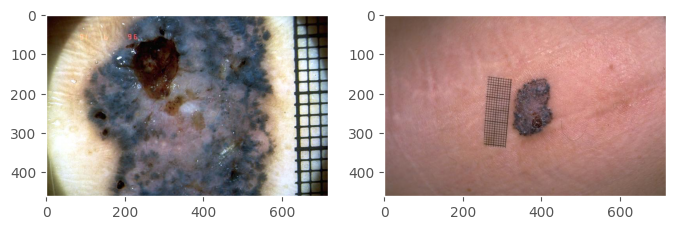

In [11]:
# Show the derm and clinical image for a single case.
row_index = 3
derm = derm_data_group.derm_image(row_index=row_index)
clinic = derm_data_group.clinic_image(row_index=row_index)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(derm)
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(clinic)
plt.grid(False)
# Show the corresponding info.
print(derm_data_group.df.iloc[row_index])

<h1>Example using Deep Features and a Linear Model</h1>

In [12]:
# Get the dermatology and clinic training images and corresponding labels.
train_derm_paths = derm_data_group.get_img_paths(data_type='train', img_type='derm')
train_clinic_paths = derm_data_group.get_img_paths(data_type='train', img_type='clinic')
train_labels = derm_data_group.get_labels(data_type='train', one_hot=False)

# The 8 abbreviations that indicate the different types of categories 
# i.e., 1 diagnosis + 7 critiera.
print(train_labels.keys())

dict_keys(['DIAG', 'PN', 'BWV', 'VS', 'PIG', 'STR', 'DaG', 'RS'])


In [13]:
# Get the dermatology and clinic test images and corresponding labels.
test_derm_paths = derm_data_group.get_img_paths(data_type='test', img_type='derm')
test_clinic_paths = derm_data_group.get_img_paths(data_type='test', img_type='clinic')
test_labels = derm_data_group.get_labels(data_type='test', one_hot=False)

In [14]:
# Note, you can get images for validation by:
valid_derm_paths = derm_data_group.get_img_paths(data_type='valid', img_type='derm')
print(len(valid_derm_paths))
# We don't use them within this demo, but they could/should be used when choosing hyper-parameters.

203


In [15]:
# Choose a pretrained model to extract features from.
# Can use any model. Just have to make sure the input_shape is appropriate.
import tensorflow as tf
from keras.applications.mobilenet import preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2
input_shape = (224, 224, 3)
model = MobileNetV2(include_top=False, input_shape=input_shape)

In [16]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [17]:
# Apply cropping around the boundary of the images to get rid of the black boundary.
crop_amount= 25

<h2>Extract features from dermatology images</h2>

In [18]:
# Extract features from training images (might take a few minutes... ideally you have a GPU.)
train_derm_f = deep_features(img_paths=train_derm_paths, model=model, 
                             func_preprocess_input=preprocess_input, 
                             target_size=input_shape, crop_amount=crop_amount)

1/1 [==============================] - 0s 43ms/step


In [19]:
# Extract features from testing images (might take a few minutes)
test_derm_f = deep_features(img_paths=test_derm_paths, model=model, 
                            func_preprocess_input=preprocess_input, 
                            target_size=input_shape, crop_amount=crop_amount)

1/1 [==============================] - 0s 40ms/step


In [20]:
# Number_of_images x number_of_features 
print(train_derm_f.shape) # 413 images. 
print(test_derm_f.shape) # 395 images.

(413, 1280)
(395, 1280)


<h2>Extract features from clinical images</h2>

In [21]:
# May take a bit of time.
train_clinic_f = deep_features(img_paths=train_clinic_paths, model=model, 
                               func_preprocess_input=preprocess_input, 
                               target_size=input_shape, crop_amount=crop_amount)

test_clinic_f = deep_features(img_paths=test_clinic_paths, model=model, 
                              func_preprocess_input=preprocess_input, 
                              target_size=input_shape, crop_amount=crop_amount)
print(train_clinic_f.shape)
print(test_clinic_f.shape)

1/1 [==============================] - 0s 50ms/step
(413, 1280)
(395, 1280)


<h2>Train a linear model on the images</h2>

In [22]:
# Select one of the categories.
abbrev = 'DIAG'
# These are the labels associated with the given abbreviation.
label_names = derm_data_group.get_label_by_abbrev(abbrev).abbrevs.values

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36:

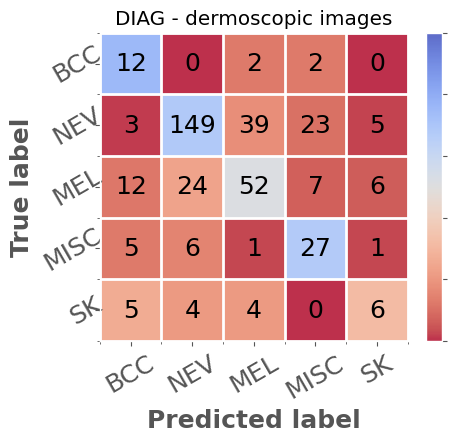

In [23]:
# Linear classifier for derm images.
reg = LogisticRegression(C=0.01, class_weight='balanced').fit(train_derm_f, train_labels[abbrev])

# Make predictions.
test_preds = reg.predict(test_derm_f)

# Display a confusion matrix.
plot_confusion(y_true=test_labels[abbrev], y_pred=test_preds, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images');

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36:

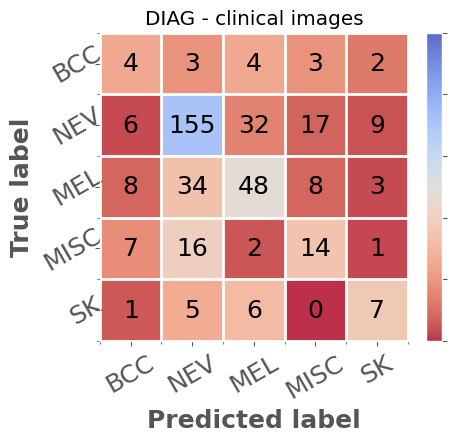

In [24]:
# Linear classifier on clinic images. 
reg = LogisticRegression(C=0.01, class_weight='balanced').fit(train_clinic_f, train_labels[abbrev])
test_preds = reg.predict(test_clinic_f)
# Performance is worse for clinical images as they are less standardized than derm images.
plot_confusion(y_true=test_labels[abbrev], y_pred=test_preds, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - clinical images');

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36:

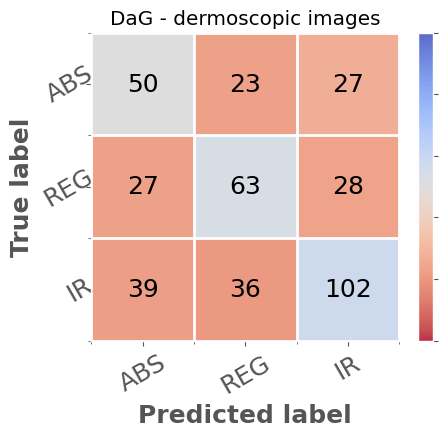

In [25]:
# Example with category "Dots and Globules" using derm images.
abbrev = 'DaG'
reg = LogisticRegression(C=0.01, class_weight='balanced').fit(train_derm_f, train_labels[abbrev])
test_preds = reg.predict(test_derm_f)
label_names = derm_data_group.get_label_by_abbrev(abbrev).abbrevs.values
plot_confusion(y_true=test_labels[abbrev], y_pred=test_preds, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images');